In [82]:
# gestión de datos
import numpy as np
import pandas as pd
import sqlite3

# # fechas
# import datetime as dt
# from datetime import datetime
# from dateutil.relativedelta import relativedelta

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# modelos
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

# metricas
import sklearn.metrics as metrics

# hiperparametrizado
from sklearn.model_selection import GridSearchCV

# guradar modelo
import pickle

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

In [83]:
con = sqlite3.connect("classic.db")

In [84]:
# Consulta de productos más vendidos y sus ingresos
q = """
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS unidades_totales,              
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
    FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY ingresos_totales DESC
"""

pd.read_sql(q, con)



,productName,unidades_totales,ingresos_totales
0,1992 Ferrari 360 Spider red,1808,276839.98
1,2001 Ferrari Enzo,1019,190755.86
2,1952 Alpine Renault 1300,961,190017.96
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00
4,1968 Ford Mustang,933,161531.48
...,...,...,...
104,1982 Ducati 996 R,906,33268.76
105,1958 Chevy Corvette Limited Edition,983,31627.96
106,1982 Lamborghini Diablo,912,30972.87
107,1936 Mercedes Benz 500k Roadster,824,29763.39


In [85]:
# Consulta de participación porcentual de ingresos por producto
q = """
WITH ventas AS (
    SELECT 
        p.productName,
        SUM(od.quantityOrdered) AS unidades_totales,
        ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
    FROM orderDetails od
    INNER JOIN products p ON od.productCode = p.productCode
    GROUP BY p.productName)
SELECT 
    productName,
    unidades_totales,
    ingresos_totales,
    ROUND((ingresos_totales * 100.0) / (SELECT SUM(ingresos_totales) FROM ventas), 2) AS porcentaje_participacion
FROM ventas
ORDER BY ingresos_totales DESC
"""
pd.read_sql(q, con)


,productName,unidades_totales,ingresos_totales,porcentaje_participacion
0,1992 Ferrari 360 Spider red,1808,276839.98,2.88
1,2001 Ferrari Enzo,1019,190755.86,1.99
2,1952 Alpine Renault 1300,961,190017.96,1.98
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,1.78
4,1968 Ford Mustang,933,161531.48,1.68
...,...,...,...,...
104,1982 Ducati 996 R,906,33268.76,0.35
105,1958 Chevy Corvette Limited Edition,983,31627.96,0.33
106,1982 Lamborghini Diablo,912,30972.87,0.32
107,1936 Mercedes Benz 500k Roadster,824,29763.39,0.31


In [86]:
# Calcular precio promedio de venta por unidad
q_unidad = """
SELECT 
    p.productName,
    SUM(od.quantityOrdered) AS unidades_totales,              
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales,
    ROUND(SUM(od.quantityOrdered * od.priceEach) / NULLIF(SUM(od.quantityOrdered), 0), 2) AS precio_promedio_unidad
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY precio_promedio_unidad DESC
"""
pd.read_sql(q_unidad, con)




,productName,unidades_totales,ingresos_totales,precio_promedio_unidad
0,1952 Alpine Renault 1300,961,190017.96,197.73
1,2001 Ferrari Enzo,1019,190755.86,187.20
2,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,173.29
3,1968 Ford Mustang,933,161531.48,173.13
4,1969 Ford Falcon,965,152543.02,158.08
...,...,...,...,...
104,1982 Ducati 996 R,906,33268.76,36.72
105,1936 Mercedes Benz 500k Roadster,824,29763.39,36.12
106,1982 Lamborghini Diablo,912,30972.87,33.96
107,1958 Chevy Corvette Limited Edition,983,31627.96,32.17


In [87]:
# conversion a dataframe y mostrar las primeras 10 filas
df_productos = pd.read_sql(q, con)
df_productos.head(10)

,productName,unidades_totales,ingresos_totales,porcentaje_participacion
0,1992 Ferrari 360 Spider red,1808,276839.98,2.88
1,2001 Ferrari Enzo,1019,190755.86,1.99
2,1952 Alpine Renault 1300,961,190017.96,1.98
3,2003 Harley-Davidson Eagle Drag Bike,985,170686.00,1.78
4,1968 Ford Mustang,933,161531.48,1.68
5,1969 Ford Falcon,965,152543.02,1.59
6,1980s Black Hawk Helicopter,1040,144959.91,1.51
7,1998 Chrysler Plymouth Prowler,986,142530.63,1.48
8,1917 Grand Touring Sedan,918,140535.60,1.46
9,2002 Suzuki XREO,1028,135767.03,1.41


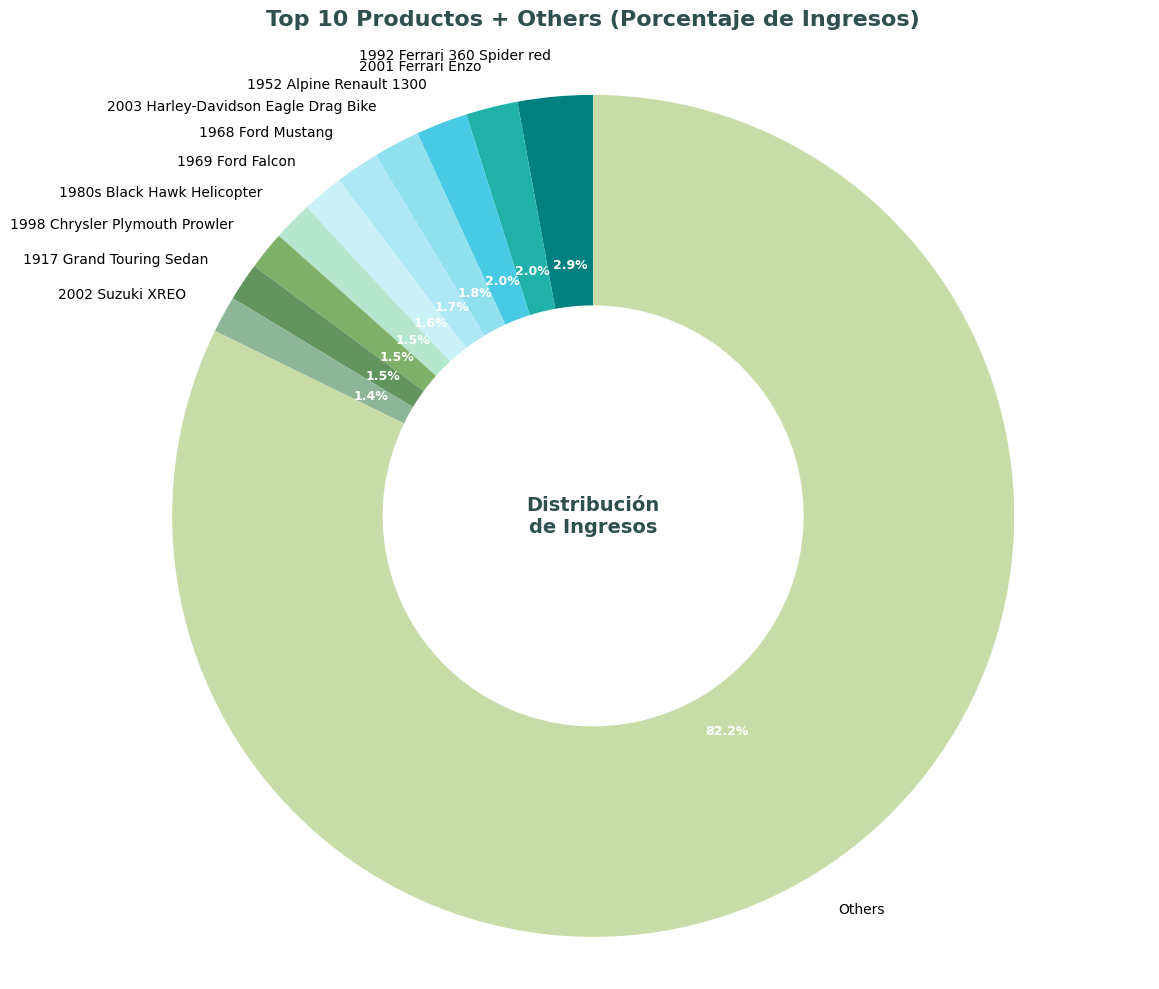

In [88]:
# Tomar los 10 primeros productos
df_top10 = df_productos.head(10)

# Calcular el total del resto
otros = pd.DataFrame({
    "productName": ["Others"],
    "porcentaje_participacion": [df_productos["porcentaje_participacion"].iloc[10:].sum()]
})

# Unir los 10 primeros con el grupo "Others"
df_plot = pd.concat([df_top10, otros], ignore_index=True)

# Crear paleta de colores con teal
colors = ['#008080', '#20B2AA', '#48CAE4', '#90E0EF', '#ADE8F4', 
          '#CAF0F8', '#B5E7CE', '#7FB069', '#629460', '#8DB596', '#C7DCA7']

# Graficar como dona
plt.figure(figsize=(12, 10))
wedges, texts, autotexts = plt.pie(
    df_plot["porcentaje_participacion"],
    labels=df_plot["productName"],
    autopct="%1.1f%%",
    startangle=90,
    colors=colors,
    wedgeprops=dict(width=0.5),  # Esto crea el efecto de dona
    textprops={'fontsize': 10}
)

# Personalizar el texto de porcentajes
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(9)

# Añadir título en el centro de la dona
plt.text(0, 0, 'Distribución\nde Ingresos', 
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=14, 
         fontweight='bold',
         color='darkslategray')

plt.title("Top 10 Productos + Others (Porcentaje de Ingresos)", 
          fontsize=16, fontweight='bold', pad=20, color='darkslategray')

plt.axis('equal')
plt.tight_layout()
plt.show()

In [89]:
# Frecuencia de pedidos por producto
q_rotacion = """
SELECT 
    p.productName,
    COUNT(DISTINCT o.orderNumber) AS frecuencia_pedidos,
    ROUND(SUM(od.quantityOrdered) / COUNT(DISTINCT o.orderNumber), 0) AS unidades_promedio_por_pedido
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
INNER JOIN orders o ON od.orderNumber = o.orderNumber
GROUP BY p.productName
ORDER BY frecuencia_pedidos DESC
"""
pd.read_sql(q_rotacion, con)

,productName,frecuencia_pedidos,unidades_promedio_por_pedido
0,1992 Ferrari 360 Spider red,53,34.0
1,P-51-D Mustang,28,32.0
2,HMS Bounty,28,32.0
3,F/A 18 Hornet 1/72,28,37.0
4,Diamond T620 Semi-Skirted Tanker,28,34.0
...,...,...,...
104,1932 Alfa Romeo 8C2300 Spider Sport,25,34.0
105,1917 Grand Touring Sedan,25,36.0
106,1911 Ford Town Car,25,33.0
107,1957 Ford Thunderbird,24,31.0


In [90]:
# Frecuencia de pedidos por producto
q_rotacion = """
SELECT 
    p.productName,
    COUNT(DISTINCT o.orderNumber) AS frecuencia_pedidos,
    SUM(od.quantityOrdered) AS unidades_totales,
    ROUND(SUM(od.quantityOrdered) / COUNT(DISTINCT o.orderNumber), 2) AS unidades_promedio_por_pedido
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
INNER JOIN orders o ON od.orderNumber = o.orderNumber
GROUP BY p.productName
ORDER BY frecuencia_pedidos DESC
"""
pd.read_sql(q_rotacion, con)

,productName,frecuencia_pedidos,unidades_totales,unidades_promedio_por_pedido
0,1992 Ferrari 360 Spider red,53,1808,34.0
1,P-51-D Mustang,28,917,32.0
2,HMS Bounty,28,897,32.0
3,F/A 18 Hornet 1/72,28,1047,37.0
4,Diamond T620 Semi-Skirted Tanker,28,979,34.0
...,...,...,...,...
104,1932 Alfa Romeo 8C2300 Spider Sport,25,866,34.0
105,1917 Grand Touring Sedan,25,918,36.0
106,1911 Ford Town Car,25,832,33.0
107,1957 Ford Thunderbird,24,767,31.0


INSIGHTS ESTRATÉGICOS:

TOP Frecuencia = Productos que siempre debes tener en stock

BOTTOM Frecuencia = Candidatos a descontinuar o revisar estrategia

In [91]:
# Consulta de ingresos mensuales
q_mes = """
SELECT 
    STRFTIME('%m', o.orderDate) AS mes_num,
        ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_mensuales,
    SUM(od.quantityOrdered) AS unidades_vendidas
FROM orders o
INNER JOIN orderDetails od ON o.orderNumber = od.orderNumber
GROUP BY mes_num
ORDER BY mes_num
"""
pd.read_sql(q_mes, con)

,mes_num,ingresos_mensuales,unidades_vendidas
0,01,716815.00,7997
1,02,735098.65,7959
2,03,737920.36,8294
3,04,718244.98,7906
4,05,869235.79,9464
5,06,493841.51,5433
6,07,527503.85,5721
7,08,597584.20,6538
8,09,520497.65,5681
9,10,1014570.07,11214


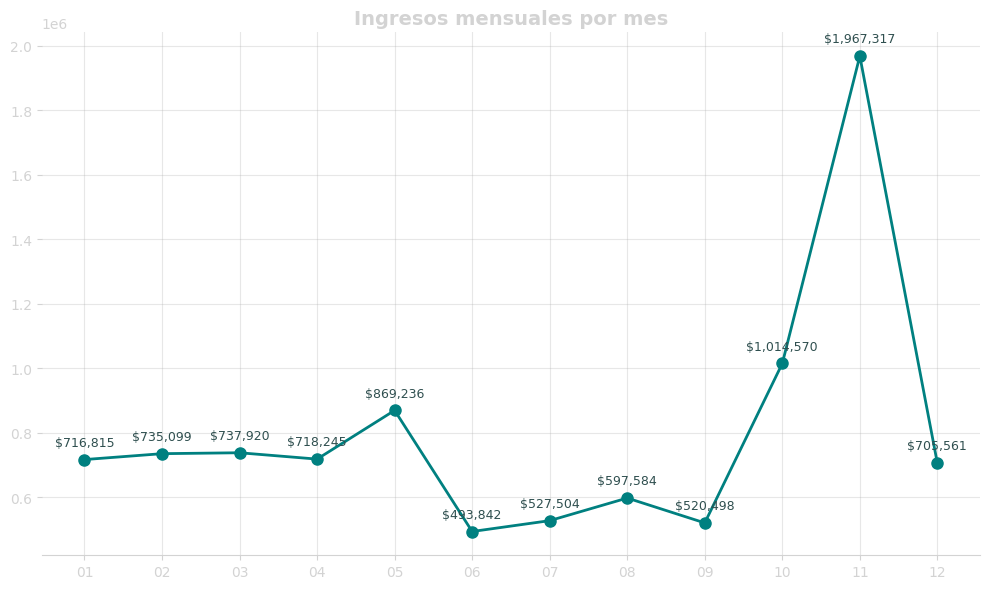

In [92]:
# Ejecutar la consulta
df_mes = pd.read_sql(q_mes, con)

# Graficar
plt.figure(figsize=(10,6))
plt.plot(df_mes['mes_num'], df_mes['ingresos_mensuales'], marker='o', color='teal', linewidth=2, markersize=8)

# Añadir valores en cada punto
for i, (mes, ingreso) in enumerate(zip(df_mes['mes_num'], df_mes['ingresos_mensuales'])):
    plt.annotate(f'${ingreso:,.0f}', 
                (mes, ingreso), 
                textcoords="offset points", 
                xytext=(0,10), 
                ha='center',
                fontsize=9,
                color='darkslategray')

plt.xticks(df_mes['mes_num'])
plt.title('Ingresos mensuales por mes', color='lightgray', fontsize=14, fontweight='bold')

# Cambiar color de los ticks a gris claro
plt.tick_params(axis='x', colors='lightgray')
plt.tick_params(axis='y', colors='lightgray')

# Configurar spines (bordes del gráfico)
ax = plt.gca()
ax.spines['top'].set_visible(False)     # Ocultar borde superior
ax.spines['right'].set_visible(False)   # Ocultar borde derecho
ax.spines['left'].set_visible(False)    # Ocultar borde izquierdo
ax.spines['bottom'].set_color('lightgray')  # Eje X en gris claro

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

ANÁLISIS:
### Estacionalidad de Ventas:
Meses pico: Octubre y Noviembre.

Meses bajos: Junio y Julio, nos sirve para planificar estrategias que sirvar para impulsar ventas.

Ciclos anuales: Entender patrones recurrentes del negocio y preparar el inventario.

### Estrategias de Marketing:
Campañas intensivas en meses bajos para activar ventas.

Aprovechamiento de meses naturalmente altos.

Presupuesto publicitario distribuido según estacionalidad.

In [93]:
q_pareto = """
SELECT 
    p.productName,
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales
FROM orderDetails od
INNER JOIN products p ON od.productCode = p.productCode
GROUP BY p.productName
ORDER BY ingresos_totales DESC
"""

df_pareto = pd.read_sql(q_pareto, con)

df_pareto

,productName,ingresos_totales
0,1992 Ferrari 360 Spider red,276839.98
1,2001 Ferrari Enzo,190755.86
2,1952 Alpine Renault 1300,190017.96
3,2003 Harley-Davidson Eagle Drag Bike,170686.00
4,1968 Ford Mustang,161531.48
...,...,...
104,1982 Ducati 996 R,33268.76
105,1958 Chevy Corvette Limited Edition,31627.96
106,1982 Lamborghini Diablo,30972.87
107,1936 Mercedes Benz 500k Roadster,29763.39


In [94]:
# Calcular porcentajes acumulados
df_pareto['ingresos_acumulados'] = df_pareto['ingresos_totales'].cumsum()
total_ingresos = df_pareto['ingresos_totales'].sum()
df_pareto['porcentaje_acumulado'] = round(df_pareto['ingresos_acumulados'] / total_ingresos * 100, 2)
df_pareto['porcentaje_productos'] = ((df_pareto.index + 1) / len(df_pareto) * 100).round(2)


# ¿Cuántos productos generan el 80% de ingresos?
productos_80 = df_pareto[df_pareto['porcentaje_acumulado'] <= 80]
num_productos_80 = len(productos_80)
porcentaje_productos_80 = round(num_productos_80 / len(df_pareto) * 100, 2)

print(f"Total de productos: {len(df_pareto)}")
print(f"Ingresos totales: ${total_ingresos:,.2f}")

print(f"{num_productos_80} productos ({porcentaje_productos_80}%) generan el 80% de los ingresos")



Total de productos: 109
Ingresos totales: $9,604,190.61
71 productos (65.14%) generan el 80% de los ingresos


## ANÁLISIS DE PARETO (80/20)

### Resultado del Análisis:
De un total de 109 productos en el catálogo, 71 productos (65.14%) generan el 80% de los ingresos totales ($9,604,190.61).

### Interpretación:

Este resultado NO cumple estrictamente con la regla de Pareto clásica (20/80), la cual establece que aproximadamente el 20% de los productos deberían generar el 80% de los ingresos. En este caso, necesitamos el 65.14% de los productos para alcanzar el 80% de ingresos, lo que indica una **distribución más equilibrada** de las ventas entre el catálogo.

### Implicaciones Estratégicas:

**1. Diversificación del Portafolio:**
El negocio no depende excesivamente de unos pocos productos estrella, sino que tiene una base de ingresos más distribuida. Esto reduce el riesgo comercial, ya que la pérdida de ventas en algunos productos puede compensarse con otros.

**2. Gestión de Inventario:**
A diferencia de un escenario Pareto puro, donde se podría concentrar el inventario en pocos productos, aquí se requiere mantener stock de una mayor cantidad de productos (71 items) para asegurar el 80% de los ingresos. Esto implica mayor inversión en inventario y logística más compleja.

**3. Optimización de Recursos:**
Aunque 71 productos es un número significativo, aún representa una oportunidad de optimización: los 38 productos restantes (34.86% del catálogo) solo generan el 20% de los ingresos. Estos productos son candidatos para:
- Revisar estrategia de precios
- Evaluar descontinuación
- Minimizar niveles de stock

**4. Enfoque Comercial:**
El equipo de ventas debe concentrar esfuerzos en mantener y potenciar los 71 productos críticos, mientras se evalúa la viabilidad de los 38 productos de cola larga.

### Recomendaciones:

- **Prioridad Alta:** Asegurar disponibilidad constante de los 71 productos que generan el 80% de ingresos
- **Estrategia Comercial:** Implementar promociones cruzadas entre productos de alto y bajo rendimiento para equilibrar la distribución

# Convertir base de datos a data frame

In [95]:
# Query para predicción de ventas mensuales TOTALES
query = """
SELECT 
    STRFTIME('%Y-%m', o.orderDate) AS año_mes,
    STRFTIME('%Y', o.orderDate) AS año,
    STRFTIME('%m', o.orderDate) AS mes,
    SUM(od.quantityOrdered) AS unidades_vendidas,
    ROUND(SUM(od.quantityOrdered * od.priceEach), 2) AS ingresos_totales,
    COUNT(DISTINCT o.orderNumber) AS numero_ordenes,
    COUNT(DISTINCT o.customerNumber) AS clientes_unicos,
    ROUND(AVG(od.quantityOrdered * od.priceEach), 2) AS ticket_promedio
FROM orders o
INNER JOIN orderDetails od ON o.orderNumber = od.orderNumber
GROUP BY año_mes, año, mes
ORDER BY año_mes
"""

df = pd.read_sql(query, con)

# Crear variable target: ingresos del siguiente mes
df['target_ingresos'] = df['ingresos_totales'].shift(-1)

# Features lag (ventas de meses anteriores)
df['ingresos_mes_1'] = df['ingresos_totales'].shift(1)
df['ingresos_mes_2'] = df['ingresos_totales'].shift(2)
df['ingresos_mes_3'] = df['ingresos_totales'].shift(3)

# Media móvil
df['media_movil_3m'] = df['ingresos_totales'].rolling(window=3).mean()

# Convertir a numérico
df['mes'] = df['mes'].astype(int)
df['año'] = df['año'].astype(int)

# Eliminar nulos
df = df.dropna()

# Guardar
df.to_csv('datos_ventas_mensuales.csv', index=False, encoding='utf-8')

print(f"Dataset: {len(df)} meses de datos")
df.head(10)

Dataset: 25 meses de datos


,año_mes,año,mes,unidades_vendidas,ingresos_totales,numero_ordenes,clientes_unicos,ticket_promedio,target_ingresos,ingresos_mes_1,ingresos_mes_2,ingresos_mes_3,media_movil_3m
3,2003-04,2003,4,1993,185848.59,7,7,3204.29,179435.55,160517.14,128403.64,116692.77,158256.456667
4,2003-05,2003,5,2017,179435.55,6,6,3093.72,150470.77,185848.59,160517.14,128403.64,175267.093333
5,2003-06,2003,6,1685,150470.77,7,6,3201.51,201940.36,179435.55,185848.59,160517.14,171918.303333
6,2003-07,2003,7,2145,201940.36,7,7,3205.40,178257.11,150470.77,179435.55,185848.59,177282.226667
7,2003-08,2003,8,1974,178257.11,5,5,3073.40,236697.85,201940.36,150470.77,179435.55,176889.413333
8,2003-09,2003,9,2510,236697.85,8,8,3114.45,514336.21,178257.11,201940.36,150470.77,205631.773333
9,2003-10,2003,10,5731,514336.21,18,17,3136.20,988025.15,236697.85,178257.11,201940.36,309763.723333
10,2003-11,2003,11,10862,988025.15,30,29,3136.59,276723.25,514336.21,236697.85,178257.11,579686.403333
11,2003-12,2003,12,2961,276723.25,9,8,3334.02,292385.21,988025.15,514336.21,236697.85,593028.203333
12,2004-01,2004,1,3245,292385.21,8,8,3213.02,289502.84,276723.25,988025.15,514336.21,519044.536667


In [96]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25 entries, 3 to 27
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   año_mes            25 non-null     object 
 1   año                25 non-null     int64  
 2   mes                25 non-null     int64  
 3   unidades_vendidas  25 non-null     int64  
 4   ingresos_totales   25 non-null     float64
 5   numero_ordenes     25 non-null     int64  
 6   clientes_unicos    25 non-null     int64  
 7   ticket_promedio    25 non-null     float64
 8   target_ingresos    25 non-null     float64
 9   ingresos_mes_1     25 non-null     float64
 10  ingresos_mes_2     25 non-null     float64
 11  ingresos_mes_3     25 non-null     float64
 12  media_movil_3m     25 non-null     float64
dtypes: float64(7), int64(5), object(1)
memory usage: 2.7+ KB


In [97]:
# Análisis exploratorio rápido del dataset
print(f"Total de registros: {len(df)}")
print(f"Rango de fechas: {df['año_mes'].min()} a {df['año_mes'].max()}")
print(f"\nEstadísticas de la variable objetivo (target_ingresos):")
print(df['target_ingresos'].describe())

Total de registros: 25
Rango de fechas: 2003-04 a 2005-04

Estadísticas de la variable objetivo (target_ingresos):
count        25.00000
mean     360509.13880
std      211840.07881
min      150470.77000
25%      236697.85000
50%      307737.02000
75%      419327.09000
max      988025.15000
Name: target_ingresos, dtype: float64


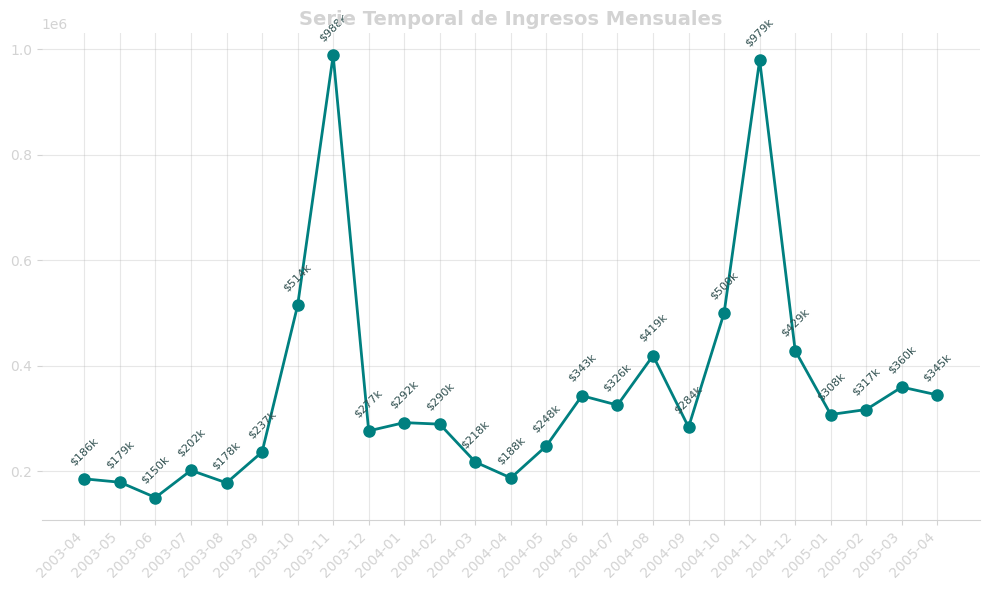

In [98]:
# Visualizar la serie temporal de ventas
plt.figure(figsize=(10, 6))
plt.plot(df['año_mes'], df['ingresos_totales'], marker='o', color='teal', linewidth=2, markersize=8)

# Añadir valores en cada punto (formato compacto en miles)
for i, (periodo, ingreso) in enumerate(zip(df['año_mes'], df['ingresos_totales'])):
    ingreso_k = ingreso / 1000  # Convertir a miles
    plt.annotate(f'${ingreso_k:.0f}k', 
                (periodo, ingreso), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center',
                fontsize=8,
                color='darkslategray',
                rotation=45)

plt.xticks(rotation=45, ha='right')
plt.title('Serie Temporal de Ingresos Mensuales', color='lightgray', fontsize=14, fontweight='bold')

# Cambiar color de los ticks a gris claro
plt.tick_params(axis='x', colors='lightgray')
plt.tick_params(axis='y', colors='lightgray')

# Configurar spines (bordes del gráfico)
ax = plt.gca()
ax.spines['top'].set_visible(False)     # Ocultar borde superior
ax.spines['right'].set_visible(False)   # Ocultar borde derecho
ax.spines['left'].set_visible(False)    # Ocultar borde izquierdo
ax.spines['bottom'].set_color('lightgray')  # Eje X en gris claro

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [99]:
# Preparar datos para el modelo
# Seleccionar features (variables predictoras)
features = [
    'año', 'mes', 
    'unidades_vendidas', 'numero_ordenes', 'clientes_unicos', 'ticket_promedio',
    'ingresos_mes_1', 'ingresos_mes_2', 'ingresos_mes_3', 
    'media_movil_3m'
]

X = df[features]
y = df['target_ingresos']

print(f"Shape de X (features): {X.shape}")
print(f"Shape de y (target): {y.shape}")

Shape de X (features): (25, 10)
Shape de y (target): (25,)


In [100]:
# Dividir en train y test (80% train, 20% test)
# Importante: NO usar shuffle=True para datos temporales
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    shuffle=False  # Mantener orden temporal
)

print(f"Train set: {X_train.shape[0]} meses")
print(f"Test set: {X_test.shape[0]} meses")

Train set: 20 meses
Test set: 5 meses


In [101]:
# Escalar los datos (normalización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✓ Datos escalados correctamente")

✓ Datos escalados correctamente


In [102]:
# Entrenar modelos de regresión incluyendo XGBoost
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Diccionario para almacenar modelos
modelos = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=1.0),
    'Lasso': Lasso(alpha=1.0),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42, learning_rate=0.1)
}

# Entrenar y evaluar cada modelo
resultados = {}

for nombre, modelo in modelos.items():
    # Entrenar
    modelo.fit(X_train_scaled, y_train)
    
    # Predecir
    y_pred = modelo.predict(X_test_scaled)
    
    # Métricas
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    resultados[nombre] = {
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2,
        'modelo': modelo,
        'predicciones': y_pred
    }
    
    print(f"\n{nombre}:")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  R²:   {r2:.4f}")


Linear Regression:
  MAE:  $454,281.66
  RMSE: $559,344.84
  R²:   -137.8832

Ridge:
  MAE:  $69,590.22
  RMSE: $81,620.72
  R²:   -1.9573

Lasso:
  MAE:  $335,222.44
  RMSE: $361,676.08
  R²:   -57.0671

Random Forest:
  MAE:  $95,046.57
  RMSE: $109,688.16
  R²:   -4.3408

Gradient Boosting:
  MAE:  $113,245.77
  RMSE: $115,966.34
  R²:   -4.9697

XGBoost:
  MAE:  $76,923.05
  RMSE: $84,092.97
  R²:   -2.1391


In [106]:
# Usar modelo Ridge
mejor_modelo = resultados['Ridge']['modelo']
mejor_modelo_pred = resultados['Ridge']['predicciones']

# Guardar modelo Ridge y scaler
with open('modelo_ventas_ridge.pkl', 'wb') as f:
    pickle.dump(mejor_modelo, f)

with open('scaler_ventas.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✓ Modelo Ridge y scaler guardados correctamente")

✓ Modelo Ridge y scaler guardados correctamente


In [108]:
# Predecir ventas futuras para los próximos 12 meses
ultimo_mes = df.iloc[-1:].copy()

predicciones_futuras = []
meses_futuros = []

print("🔮 PREDICCIONES PARA EL PRÓXIMO AÑO:\n")

for i in range(1, 13):  # 12 meses
    mes_actual = int(ultimo_mes['mes'].values[0])
    año_actual = int(ultimo_mes['año'].values[0])
    
    nuevo_mes = mes_actual + i
    nuevo_año = año_actual
    
    # Ajustar año si pasa de diciembre
    if nuevo_mes > 12:
        nuevo_mes = nuevo_mes - 12
        nuevo_año += 1
    
    # Crear features para predicción (usando promedios históricos)
    features_futuro = {
        'año': nuevo_año,
        'mes': nuevo_mes,
        'unidades_vendidas': df['unidades_vendidas'].mean(),
        'numero_ordenes': df['numero_ordenes'].mean(),
        'clientes_unicos': df['clientes_unicos'].mean(),
        'ticket_promedio': df['ticket_promedio'].mean(),
        'ingresos_mes_1': predicciones_futuras[-1] if i > 1 else ultimo_mes['ingresos_totales'].values[0],
        'ingresos_mes_2': predicciones_futuras[-2] if i > 2 else ultimo_mes['ingresos_mes_1'].values[0],
        'ingresos_mes_3': predicciones_futuras[-3] if i > 3 else ultimo_mes['ingresos_mes_2'].values[0],
        'media_movil_3m': np.mean(predicciones_futuras[-3:]) if i > 3 else ultimo_mes['media_movil_3m'].values[0]
    }
    
    X_futuro = pd.DataFrame([features_futuro])[features]
    X_futuro_scaled = scaler.transform(X_futuro)
    
    prediccion = mejor_modelo.predict(X_futuro_scaled)[0]
    predicciones_futuras.append(prediccion)
    
    mes_label = f"{nuevo_año}-{nuevo_mes:02d}"
    meses_futuros.append(mes_label)
    
    print(f"{mes_label}: ${prediccion:,.2f}")

print(f"\n✓ Predicciones completadas para 12 meses")

🔮 PREDICCIONES PARA EL PRÓXIMO AÑO:

2005-05: $367,903.36
2005-06: $427,868.20
2005-07: $466,223.80
2005-08: $537,414.22
2005-09: $583,161.59
2005-10: $657,700.45
2005-11: $705,466.08
2005-12: $780,886.03
2006-01: $14,953.91
2006-02: $708,300.74
2006-03: $-27,736.87
2006-04: $760,259.20

✓ Predicciones completadas para 12 meses


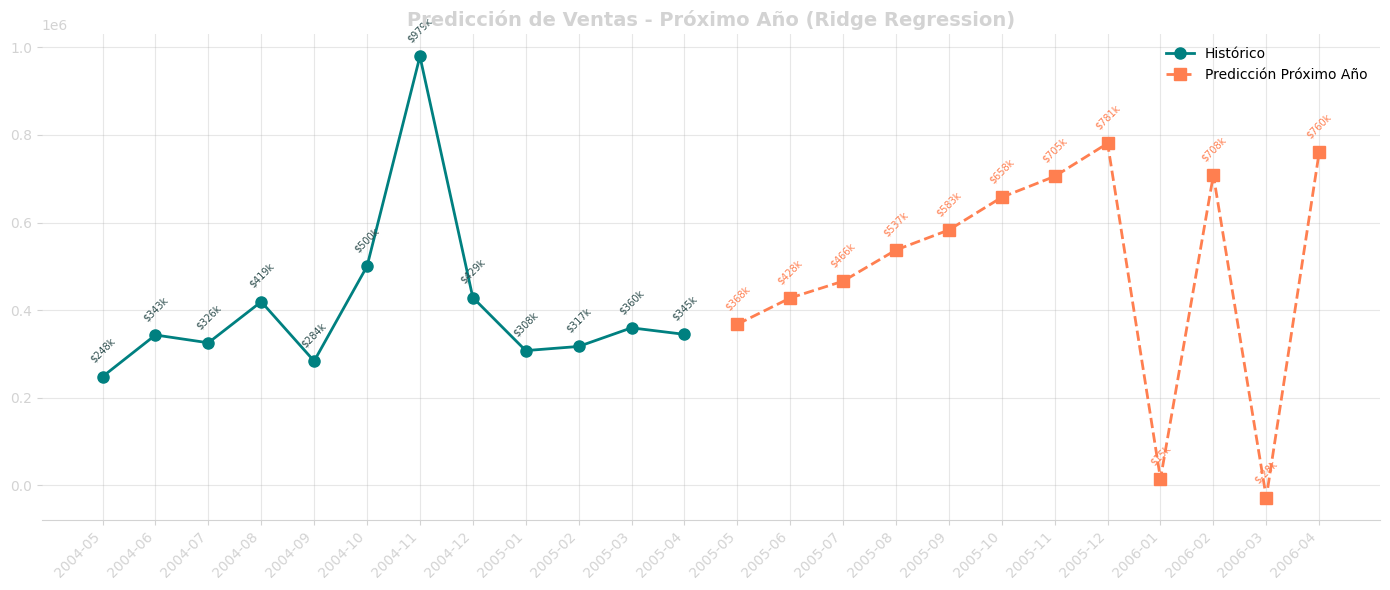

In [109]:
# Visualizar predicciones del próximo año
plt.figure(figsize=(14, 6))

# Histórico (últimos 12 meses)
ultimos_12 = df.tail(12)
plt.plot(range(len(ultimos_12)), ultimos_12['ingresos_totales'].values, 
         marker='o', label='Histórico', color='teal', linewidth=2, markersize=8)

# Predicciones futuras
inicio_futuro = len(ultimos_12)
plt.plot(range(inicio_futuro, inicio_futuro + len(predicciones_futuras)), 
         predicciones_futuras, 
         marker='s', label='Predicción Próximo Año', color='coral', linewidth=2, markersize=8, linestyle='--')

# Valores históricos
for i, valor in enumerate(ultimos_12['ingresos_totales']):
    valor_k = valor / 1000
    plt.annotate(f'${valor_k:.0f}k', 
                (i, valor), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center',
                fontsize=7,
                color='darkslategray',
                rotation=45)

# Valores futuros
for i, valor in enumerate(predicciones_futuras):
    valor_k = valor / 1000
    plt.annotate(f'${valor_k:.0f}k', 
                (inicio_futuro + i, valor), 
                textcoords="offset points", 
                xytext=(0, 10), 
                ha='center',
                fontsize=7,
                color='coral',
                rotation=45)

todas_etiquetas = list(ultimos_12['año_mes']) + meses_futuros
plt.xticks(range(len(todas_etiquetas)), todas_etiquetas, rotation=45, ha='right')

plt.title('Predicción de Ventas - Próximo Año (Ridge Regression)', color='lightgray', fontsize=14, fontweight='bold')
plt.legend(loc='best', frameon=False, fontsize=10)

plt.tick_params(axis='x', colors='lightgray')
plt.tick_params(axis='y', colors='lightgray')

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_color('lightgray')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()